# От регрессии к нейросети

Дополнение к статье нейросеть за пять минут.  http://glebmikhaylov.com/нейронная-сеть-за-5-минут/

Создадим данные, на которых будем тестить нейронки.

Populating the interactive namespace from numpy and matplotlib


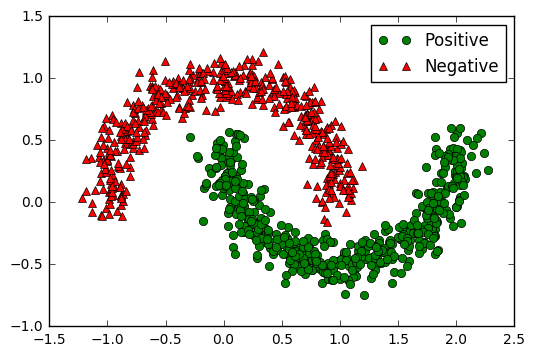

In [1]:
%pylab inline

from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.xlim([-1.5,2.5])
plt.ylim([-1,1.5])
plt.show()

Сгенерим набор точек, чтобы сторить границы, по кототорым модель разделяет классы.

In [2]:
X1_g, X2_g = np.meshgrid(np.arange(-1.5,2.5,0.05),np.arange(-1.5,2.5,0.05))
X_grid = np.array([X1_g.ravel(),X2_g.ravel()]).T

Создадим тренировочный и тестовый сеты

In [3]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons[:-test_size]
X_test = X_moons[-test_size:]
y_train = y_moons[:-test_size].reshape(-1, 1)
y_test = y_moons[-test_size:].reshape(-1, 1)

Импортируем tensorflow и создаем вспомогательные функции: 
    - reset_graph - обнуляет результаты запусков tensorflow, что-то на подобие Kerner->restart в Jupyter
    - log_dir - генерит название папки, в которой будут храниться логи tensorflow. Функция нужна, чтобы запускать tensorboard и визуализировать вычисления.
    - random_batch - нарезает дата сет на кусочки

In [4]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

Однослойная нейронка = логистическая регрессия

<img src="files/logreg_arch2.png">

Создадим функцию, с помощью которой будем создавить слои.

In [5]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

Параметры:
- X - входные данные
- n_neurons - количество нейронов в сети
- name - название слоя для отображения в tensorboard
- функция активации

Начинка:
- n_inputs - определяем размерность входных данных - сколько переменных пришло
- stddev - считатем стандартное отклонение для инициализации вес. Ученые доказали, что нужно вычислять его так
- init - создаем распределение из которого случайным образом сгенерятся веса
- W - веса
- b - смещение
- Z - перемножаем веса на переменные и суммируем, добавляем смещение

Вывод:

Функция возвращает Z пропущенную через функцию активации.

Создадим логистическую регрессию с помощью нейронного слоя.

In [6]:
reset_graph()
n_outputs = 1
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, X_moons.shape[1]), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("logreg"):
    predict = neuron_layer(X, n_outputs, name="predict",
                           activation=tf.nn.sigmoid)
    
with tf.name_scope("loss"):
    log_loss = tf.losses.log_loss(labels=y,predictions=predict)
    loss = tf.reduce_mean(log_loss, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) #AdamOptimizer
    training_op = optimizer.minimize(loss)
    loss_summary = tf.summary.scalar('log_loss', loss) # для tensorboard

with tf.name_scope("eval"):
    threshold = tf.constant(0.5, name="threshold")
    pred_label = tf.cast(tf.less_equal(threshold,predict),tf.int64)
    correct = tf.equal(y,pred_label)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

1) reset_graph() - обнуляем текущий граф, которые есть tensorflow (tf). Это особенность архитектуры tf. Tensor - массив чисел, можно представить себе, что тензор это по сути обычный np.array из numpy. Flow - поток. С помощью питоновского кода можно создать поток из тензоров - граф. Поток тензоров - это то, как они будут между собой перемножаться и взаимодействовать.

2) n_output - количество выходных нейронов. Я буду предсказывать один класс, значит у меня будет один выходной нейрон.

3) X, y - заготавливаем "ёмкости" для переменных и таргетов. В эти массивы будут последовательно закладываться кусочки обучающий выборки, а модель будет на них обучаться.

4) with tf.name_scope("logreg") - создаем нейронный слой с одним нейроном и активацией сигмоид. Конструкции with нужны для архитектурных особенностей tf.

5) with tf.name_scope("loss") - определяем функцию потерь. В случае регрессии - это логистическая функция потерь.

6) with tf.name_scope("train") - определяем, что мы будем оптимизировать в процессе тренировки. Естественно это функция потерь. Круто, что нужно просто указать, что оптимизировать и с каким шагом (learning_rate), а tf сам найдем производные и сделает градиентный спуск.

7) with tf.name_scope("eval") - пропишем как делать предсказания и считать точность.

8) init и saver - служебные штуки tf.

Обучаем модель

In [7]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(len(X_train) / batch_size))

logdir = log_dir("logreg11")
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        accuracy_val = accuracy.eval({X: X_test, y: y_test})
        pred = predict.eval({X: X_test, y: y_test})
        
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)          
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\acc:", accuracy_val)
            
    y_proba_val = predict.eval(feed_dict={X: X_test, y: y_test})
    y_proba_des = predict.eval(feed_dict={X: X_grid})

Epoch: 0 cc: 0.82
Epoch: 100 cc: 0.845
Epoch: 200 cc: 0.855
Epoch: 300 cc: 0.855
Epoch: 400 cc: 0.855
Epoch: 500 cc: 0.86
Epoch: 600 cc: 0.86
Epoch: 700 cc: 0.865
Epoch: 800 cc: 0.87
Epoch: 900 cc: 0.87


Модель тренируется с помощью батчей, т.е. дата сет скармливается маленькими рандомными кусочками и много раз. В цикле перебираются эти кусочки и для каждого запускается training_op - оптимизация функции потерь. После окончания обучения считаются предсказания для тестовой выборки и для сетки значений, чтобы построить график области, по которой модель разделяет классы.

Построим предсказания.

precision:  0.861386138614
recall  0.878787878788


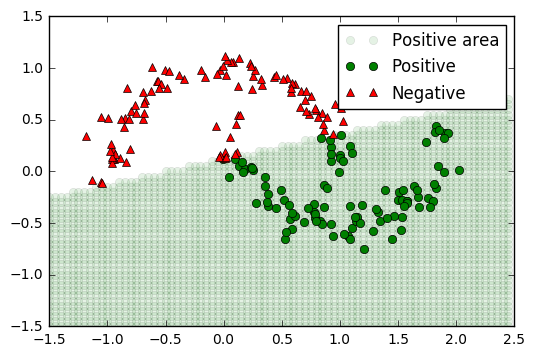

In [8]:
y_pred = (y_proba_val >= 0.5)

print('precision: ',precision_score(y_test, y_pred))
print('recall ',recall_score(y_test, y_pred))

y_pred_des = (y_proba_des >= 0.5)
y_pred_idx1 = y_pred_des.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_grid[y_pred_idx1, 0], X_grid[y_pred_idx1, 1],'go',alpha=0.1,label="Positive area")
#plt.plot(X_grid[~y_pred_idx1, 0], X_grid[~y_pred_idx1, 1])

y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 0], X_test[y_pred_idx, 1], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 0], X_test[~y_pred_idx, 1], 'r^', label="Negative")

plt.legend()
plt.show()

Модель линейная и допускает много ошибок. Добавим в нейронку скрытый слой из пяти нейронов.

<img src="files/neuro_n5_arch.png">

In [9]:
n_hidden = 5
n_outputs = 1

reset_graph()

learning_rate = 0.01
X = tf.placeholder(tf.float32, shape=(None, X_moons.shape[1]), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("NN"):
    
    hidden = neuron_layer(X,n_hidden,name='hidden',
                          activation=tf.nn.relu)
    predict = neuron_layer(hidden, n_outputs, name="predict",
                           activation=tf.nn.sigmoid)
    
with tf.name_scope("loss"):
    log_loss = tf.losses.log_loss(labels=y,predictions=predict)
    loss = tf.reduce_mean(log_loss, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    loss_summary = tf.summary.scalar('log_loss', loss) # для tensorboard

with tf.name_scope("eval"):
    threshold = tf.constant(0.5, name="threshold")
    pred_label = tf.cast(tf.less_equal(threshold,predict),tf.int64)
    correct = tf.equal(y,pred_label)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Изменения произошли в первой части - там, где создаем слои. Теперь их два:

1) hidden - слой с пятью нейронами и активацией relu.

2) predict - такой же слой, как в первой модели, только на вход берет результаты скрытого слоя.

Все остальное без изменений.

Обучаем

In [10]:
n_epochs = 1000
batch_size = 50
learning_rate = 0.01
n_batches = int(np.ceil(len(X_train) / batch_size))

logdir = log_dir("logreg11")
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())


with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        accuracy_val = accuracy.eval({X: X_test, y: y_test})
        pred = predict.eval({X: X_test, y: y_test})
        
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)          
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tacc:", accuracy_val)
            
    y_proba_val = predict.eval(feed_dict={X: X_test, y: y_test})
    y_proba_des = predict.eval(feed_dict={X: X_grid})

Epoch: 0 	acc: 0.275
Epoch: 100 	acc: 0.865
Epoch: 200 	acc: 0.91
Epoch: 300 	acc: 0.92
Epoch: 400 	acc: 0.925
Epoch: 500 	acc: 0.93
Epoch: 600 	acc: 0.94
Epoch: 700 	acc: 0.945
Epoch: 800 	acc: 0.965
Epoch: 900 	acc: 0.975


Строим предсказания.

precision:  0.97
recall  0.979797979798


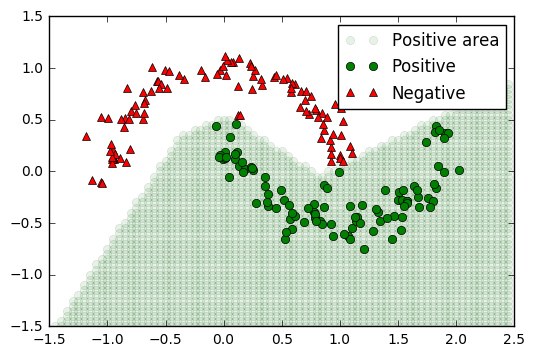

In [11]:
y_pred = (y_proba_val >= 0.5)

print('precision: ',precision_score(y_test, y_pred))
print('recall ',recall_score(y_test, y_pred))

y_pred_des = (y_proba_des >= 0.5)
y_pred_idx1 = y_pred_des.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_grid[y_pred_idx1, 0], X_grid[y_pred_idx1, 1],'go',alpha=0.1,label="Positive area")
#plt.plot(X_grid[~y_pred_idx1, 0], X_grid[~y_pred_idx1, 1])

y_pred = (y_proba_val >= 0.5)
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 0], X_test[y_pred_idx, 1], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 0], X_test[~y_pred_idx, 1], 'r^', label="Negative")

plt.legend()
plt.show()